In [2]:
import os
import torch

from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Rectangle
import json

import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
gt_coco = COCO('/home/prml/Dataset/coco2017/annotations/instances_val2017.json')

loading annotations into memory...
Done (t=0.53s)
creating index...
index created!


In [4]:
pred_df = pd.read_csv('/home/prml/StudentsWork/ChanYoung/Experiments/rt_detr/AAAI2025/superclass_silu2333333/pred_iou.csv')

pred_min_xs, pred_min_ys, pred_max_xs, pred_max_ys = [], [], [], []
for string in pred_df['pred_box']:
    min_x, min_y, max_x, max_y = string.split('[')[1].split(']')[0].split(',')
    
    pred_min_xs.append(float(min_x))
    pred_min_ys.append(float(min_y))
    pred_max_xs.append(float(max_x))
    pred_max_ys.append(float(max_y))
    
pred_df['pred_min_x'] = pred_min_xs
pred_df['pred_min_y'] = pred_min_ys
pred_df['pred_max_x'] = pred_max_xs
pred_df['pred_max_y'] = pred_max_ys

pred_df.drop(columns=['gt_box', 'pred_box'], inplace=True)
pred_df

,pred_score,max_iou,pred_class,gt_class,img_id,gt_ann_id,pred_min_x,pred_min_y,pred_max_x,pred_max_y
0,0.942287,0.946754,1,1.0,397133,200887.0,384.717438,68.720520,499.659302,347.225037
1,0.918423,0.925807,7,51.0,397133,716434.0,57.576885,288.321655,134.855957,327.988770
2,0.897394,0.961529,7,51.0,397133,713388.0,30.687696,343.501434,99.189674,385.472534
3,0.831097,0.825147,7,51.0,397133,1902250.0,154.798035,167.996124,183.412460,185.288544
4,0.824789,0.932011,1,1.0,397133,1218137.0,0.033207,263.423706,60.323288,300.463409
...,...,...,...,...,...,...,...,...,...,...
1499995,0.080740,0.310234,9,1.0,15335,1705756.0,151.467255,17.611464,555.492371,167.040909
1499996,0.080512,0.106153,10,1.0,15335,1277736.0,35.643776,388.321747,211.006897,436.823029
1499997,0.080188,0.392966,9,1.0,15335,1277736.0,0.222349,147.947495,110.597527,436.330841
1499998,0.079959,0.257445,7,1.0,15335,1705756.0,365.138885,51.564491,432.471588,125.800110


In [5]:
df = pd.read_csv('/home/prml/StudentsWork/ChanYoung/Experiments/rt_detr/AAAI2025/superclass_silu2333333/problems.csv')
df.drop(columns=['pred_box', 'gt_box'], inplace=True)
df

,pred_score,max_iou,pred_class,gt_class,gt_ann_id,gt_img_id,super_gt_class,pred_min_x,pred_min_y,pred_w,pred_h,pred_area,gt_min_x,gt_min_y,gt_w,gt_h,gt_area
0,0.174252,0.853868,11,79,2139366,397133,11,0.503969,206.994751,188.876495,300.090790,56680.096667,0.000000,210.899994,191.360001,98.980003,18940.813503
1,0.129772,0.890764,9,62,100948,37777,9,21.146423,215.049088,87.957222,230.013596,20231.356886,26.500000,215.250000,61.500000,14.500000,891.750000
2,0.072664,0.868588,9,67,120305,37777,9,75.203789,180.423141,290.335999,229.781525,66713.848407,79.550003,178.050003,208.360001,48.700001,10147.132189
3,0.064011,0.901615,11,82,330768,37777,11,298.476166,73.788651,351.996643,229.512924,80787.778857,301.839996,74.940002,49.619999,151.440002,7514.452759
4,0.099988,0.981914,5,28,1424143,252219,5,561.023071,90.862030,639.711304,157.688934,100875.393759,560.729980,90.250000,79.269997,67.320000,5336.456150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6581,0.112240,0.952642,7,49,693495,394940,7,42.670067,440.539276,329.900116,519.116943,171256.739815,41.799999,440.239990,297.980011,78.230003,23310.977260
6582,0.132469,0.844094,9,63,98619,15335,9,2.658863,159.848938,551.588989,329.182709,181573.557595,2.060000,143.479996,545.039978,174.460007,95087.678226
6583,0.181253,0.938017,1,1,1282318,15335,1,507.034332,38.267605,558.346497,164.077667,91612.190669,508.829987,35.380001,49.410000,129.279999,6387.724720
6584,0.092394,0.967063,8,51,1538947,15335,7,0.738883,428.737122,99.784256,479.751770,47871.673427,0.280000,429.519989,98.650002,50.480000,4979.852032


In [6]:
problem_image_list = df['gt_img_id'].unique().tolist()
problem_image_list

[397133,
 37777,
 252219,
 403385,
 480985,
 458054,
 331352,
 296649,
 386912,
 502136,
 491497,
 184791,
 348881,
 181666,
 17627,
 303818,
 460347,
 322864,
 308394,
 456496,
 41888,
 565778,
 336587,
 219578,
 555705,
 500663,
 418281,
 25560,
 403817,
 85329,
 239274,
 286994,
 511321,
 314294,
 233771,
 301867,
 185250,
 356427,
 572517,
 516316,
 562121,
 382088,
 266409,
 80671,
 577539,
 104612,
 476258,
 448365,
 35197,
 349860,
 180135,
 486438,
 400573,
 370677,
 238866,
 502737,
 515579,
 515445,
 173383,
 438862,
 39956,
 321214,
 474028,
 66523,
 355257,
 63154,
 473237,
 206027,
 78915,
 544519,
 96493,
 23899,
 340175,
 578500,
 57597,
 434230,
 261061,
 383384,
 217285,
 524456,
 326541,
 213086,
 231339,
 508730,
 550426,
 368294,
 171190,
 301135,
 580294,
 494869,
 329219,
 34873,
 186980,
 127182,
 356387,
 367680,
 117425,
 365387,
 504711,
 363840,
 214720,
 311295,
 278848,
 166391,
 48153,
 459153,
 295713,
 223130,
 273132,
 198960,
 410428,
 450758,
 460160,

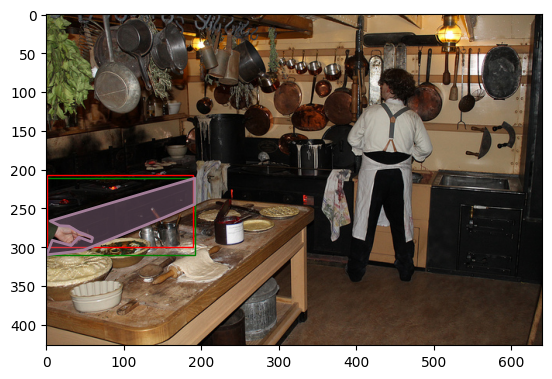

In [7]:
for img_id in problem_image_list:
    img = gt_coco.loadImgs([img_id])[0]
    
    ann_ids = df[df['gt_img_id'] == img_id]['gt_ann_id'].values    
    anns = gt_coco.loadAnns(ann_ids)
    img_path = os.path.join('/home/prml/Dataset/coco2017/val2017', img['file_name'])
    img = plt.imread(img_path)
    
    for data in df[df['gt_img_id'] == img_id].iterrows():
        data = data[1]
        x1, y1, w, h = data['gt_min_x'], data['gt_min_y'], data['gt_w'], data['gt_h']
        plt.gca().add_patch(Rectangle((x1, y1), w, h, linewidth=1, edgecolor='g', facecolor='none'))
        
        x1, y1, w, h = data['pred_min_x'], data['pred_min_y'], data['pred_w'], data['pred_h']
        plt.gca().add_patch(Rectangle((x1, y1), w-x1, h-y1, linewidth=1, edgecolor='r', facecolor='none'))
    
    plt.imshow(img)
    # plt.axis('off')
    gt_coco.showAnns(anns)
    plt.show()
    break

In [8]:
i = 0

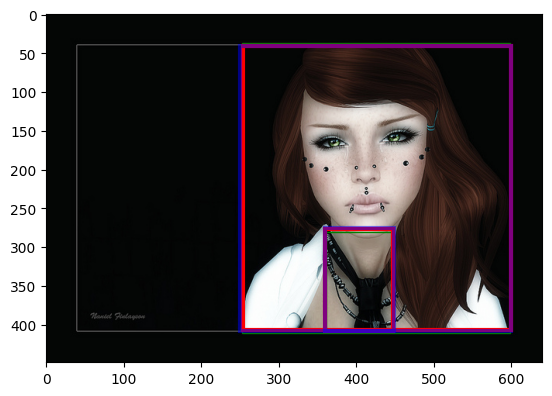

In [38]:
img_id = problem_image_list[i]
img = gt_coco.loadImgs([img_id])[0]
    
ann_ids = df[df['gt_img_id'] == img_id]['gt_ann_id'].values    
anns = gt_coco.loadAnns(ann_ids)
img_path = os.path.join('/home/prml/Dataset/coco2017/val2017', img['file_name'])
img = plt.imread(img_path)

for data in df[df['gt_img_id'] == img_id].iterrows():
    data = data[1]
    x1, y1, w, h = data['gt_min_x'], data['gt_min_y'], data['gt_w'], data['gt_h']
    plt.gca().add_patch(Rectangle((x1, y1), w, h, linewidth=1, edgecolor='g', facecolor='none'))
    
    x1, y1, w, h = data['pred_min_x'], data['pred_min_y'], data['pred_w'], data['pred_h']
    plt.gca().add_patch(Rectangle((x1, y1), w-x1, h-y1, linewidth=3, edgecolor='r', facecolor='none'))


for data in pred_df[(pred_df['img_id'] == img_id) & (pred_df['pred_score'] > 0.5)].iterrows():
    data = data[1]
    x1, y1, w, h = data['pred_min_x'], data['pred_min_y'], data['pred_max_x'], data['pred_max_y']
    plt.gca().add_patch(Rectangle((x1, y1), w-x1, h-y1, linewidth=3, edgecolor='b', facecolor='none', alpha=0.5))



plt.imshow(img)
# plt.axis('off')
# gt_coco.showAnns(anns)
plt.show()



i+=1